# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [22]:
# Incantations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Ames housing dataset
url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
ames = pd.read_csv(url).drop(columns='Id')
print(ames.shape)
ames.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

/anaconda3/envs/sandbox/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


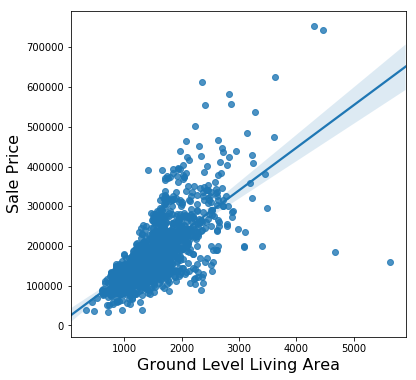

In [3]:
x = ames['GrLivArea'].values
y = ames['SalePrice'].values

fig, ax = plt.subplots(figsize=(6,6));
sns.regplot(x, y, ax=ax);
ax.set_xlabel('Ground Level Living Area', fontsize=16);
ax.set_ylabel('Sale Price', fontsize=16);

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [4]:
# For simplicity, I'm just going to use the numerical columns that 
# didn't have any nulls in them, and remove a few others just to
# bring down the total number.

ames_select = ames.select_dtypes('number')
ames_select = ames_select.drop(columns = ['LotFrontage','GarageYrBlt','MasVnrArea',
                  'YearBuilt','YearRemodAdd','MiscVal',
                     '3SsnPorch','ScreenPorch','PoolArea','MSSubClass'])
print(ames_select.shape)
ames_select.head()

(1460, 27)


,LotArea,OverallQual,OverallCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice
0,8450,7,5,706,0,150,856,856,854,0,...,8,0,2,548,0,61,0,2,2008,208500
1,9600,6,8,978,0,284,1262,1262,0,0,...,6,1,2,460,298,0,0,5,2007,181500
2,11250,7,5,486,0,434,920,920,866,0,...,6,1,2,608,0,42,0,9,2008,223500
3,9550,7,5,216,0,540,756,961,756,0,...,7,1,3,642,0,35,272,2,2006,140000
4,14260,8,5,655,0,490,1145,1145,1053,0,...,9,1,3,836,192,84,0,12,2008,250000


## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [5]:
X = ames_select.drop(columns='SalePrice')
y = ames_select['SalePrice']
X.insert(0,'const',1.0) # We need to add a column of 1's before running the model.
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     232.9
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:13:32   Log-Likelihood:                -17385.
No. Observations:                1460   AIC:                         3.482e+04
Df Residuals:                    1435   BIC:                         3.495e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.572e+05   1.46e+06      0.450

In [19]:
'''
The P-values in the output above test the null hypothesis that the coefficient for
that particular variable is equal to zero. Specifically, the P-value is the probability
that we would get a coefficient at least as extreme as we did get (with an absolute value
that far away from zero) even if the real value of the coefficient were in fact zero. The
P-values tend to be higher when the coefficient is close to zero, or surrounded by a 
very high standard error. Looks like lots of those variables have coefficients that might
as well be zero. I'm going to drop them now and re-run the model.
'''

ames_noBS = ames_select.drop(columns = ['BsmtFinSF2','BsmtUnfSF','LowQualFinSF',
                                        'BsmtHalfBath','HalfBath','Fireplaces',
                                        'GarageArea','OpenPorchSF','MoSold','YrSold'])
X = ames_noBS.drop(columns='SalePrice')
y = ames_noBS['SalePrice']
X.insert(0,'const',1.0) # We need to add a column of 1's before running the model.
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     349.1
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:24:37   Log-Likelihood:                -17388.
No. Observations:                1460   AIC:                         3.481e+04
Df Residuals:                    1443   BIC:                         3.490e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.966e+04   9601.347     -8.297

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [17]:
# This line removes all the rows from ames where at least one item is
# an outlier, defined as being 3 or more STDEVs away from the mean.
ames_mainstream = ames_noBS[(np.abs(stats.zscore(ames_noBS)) < 3).all(axis=1)]

X = ames_mainstream.drop(columns='SalePrice')
y = ames_mainstream['SalePrice']
X.insert(0,'const',1.0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     508.6
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:22:59   Log-Likelihood:                -14419.
No. Observations:                1251   AIC:                         2.887e+04
Df Residuals:                    1235   BIC:                         2.895e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.181e+04   3291.795    -15.739

It doesn't really look like any of the coefficients changed drastically.  They all wiggled around within 10% of their value, or so.  I didn't do a rigorous comparison, but I don't see any that change particularly.

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [21]:
ames_mainstream['Ln_Price'] = np.log(ames_mainstream['SalePrice'])

X = ames_mainstream.drop(columns=['SalePrice','Ln_Price'])
y = ames_mainstream['Ln_Price']
X.insert(0,'const',1.0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Ln_Price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     542.3
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:33:56   Log-Likelihood:                 739.04
No. Observations:                1251   AIC:                            -1446.
Df Residuals:                    1235   BIC:                            -1364.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.1451      0.018    285.959

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [50]:
# Calculate the VIF
vifs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Determine outliers
yikes = [i > 10 for i in vifs]

# Plot with cute srtring formatting
for col, vif, yike in zip(X.columns, vifs, yikes):
    print(f'{col:15} {vif:<7.2f} {"<<" if yike else ""}')

const           0.00    
LotArea         1.36    
OverallQual     2.65    
OverallCond     1.12    
BsmtFinSF1      1.97    
TotalBsmtSF     4.07    
1stFlrSF        76.55   <<
2ndFlrSF        104.95  <<
GrLivArea       122.04  <<
BsmtFullBath    1.75    
FullBath        2.17    
BedroomAbvGr    2.16    
KitchenAbvGr    0.00    
TotRmsAbvGrd    3.92    
GarageCars      1.92    
WoodDeckSF      1.12    
EnclosedPorch   1.06    


One thing is suspicious.  Why does KitchenAbvGr have such a low VIF? If it's the variance of this term divided by the variance of the model including all terms, then a value of zero should mean that its own variance is zero.  You know what variables have a variance of zero??  CONSTANTS.

In [53]:
ames_lowVIF['KitchenAbvGr'].describe()

count    1251.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: KitchenAbvGr, dtype: float64

I KNEW IT.

(I actually noticed this later, when the coefficient for KitchenAbvGr was the only one greater than 1, and it was the same as the column 'const'.)  I will remove that column now.

In [54]:
ames_lowVIF = ames_mainstream.drop(columns=['1stFlrSF','2ndFlrSF','GrLivArea','KitchenAbvGr'])

X = ames_lowVIF.drop(columns=['SalePrice','Ln_Price'])
y = ames_lowVIF['Ln_Price']
X.insert(0,'const',1.0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Ln_Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     582.8
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        13:57:46   Log-Likelihood:                 656.49
No. Observations:                1251   AIC:                            -1287.
Df Residuals:                    1238   BIC:                            -1220.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.1509      0.036    278.176

Once again, the coefficients don't seem to have changed too much (though removing KitchenAbvGr doubled the coefficient of 'const').  All the remaining coefficients now have an interpretation that matches my intuition somewhat. Positive coefficients add to the value of a house, whereas negathive ones reduce it (I guess nobody likes Enclosed Porches, apparently?).  Also, you can add 10% to your home value by adding a full bath, another car space in your garage, or another point to OverallQual.

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [62]:
# Back to ames_mainstream, before I removed the high VIF variables.  This is why I keep
# making more and more DFs rather than overwriting the same one.

# Also, rather than plotting the WHOLE covariance table and looking for these high-VIF 
# variables, I'm going to calculate the covariance table for a subset of the dataframe.
ames_highVIF = ames_mainstream[['1stFlrSF','2ndFlrSF','GrLivArea']]
ames_highVIF.cov()

,1stFlrSF,2ndFlrSF,GrLivArea
1stFlrSF,116563.671829,-44856.570575,70939.572698
2ndFlrSF,-44856.570575,167224.563343,122434.938892
GrLivArea,70939.572698,122434.938892,194325.109193


Those numbers sure seem big.  For context, let's look at the overall table after all.

In [61]:
ames_mainstream.cov()

,LotArea,OverallQual,OverallCond,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,WoodDeckSF,EnclosedPorch,SalePrice,Ln_Price
LotArea,1.697726e+07,631.678047,-180.452331,2.572689e+05,4.154891e+05,5.239338e+05,8.916284e+04,6.059630e+05,159.213020,301.792320,897.791908,0.0,1897.948156,769.835570,7.115673e+04,-7908.867167,9.025301e+07,516.307772
OverallQual,6.316780e+02,1.677721,-0.245385,8.559788e+01,2.508404e+02,2.050297e+02,1.496632e+02,3.515241e+02,0.058128,0.419641,0.126049,0.0,0.854839,0.550095,3.075907e+01,-8.845859,6.896699e+04,0.387398
OverallCond,-1.804523e+02,-0.245385,1.015552,-6.483525e+00,-6.898168e+01,-4.627776e+01,-2.072193e+01,-6.492269e+01,-0.012632,-0.132519,-0.011735,0.0,-0.120849,-0.174765,-8.703322e-01,4.217406,-1.006082e+04,-0.042161
BsmtFinSF1,2.572689e+05,85.597884,-6.483525,1.653232e+05,6.152450e+04,4.945244e+04,-3.277865e+04,1.538226e+04,128.518640,10.182247,-25.491022,0.0,-15.270769,56.842433,7.806017e+03,-1894.855313,9.170743e+06,49.909330
TotalBsmtSF,4.154891e+05,250.840389,-68.981678,6.152450e+04,1.355046e+05,1.047272e+05,-4.376420e+04,5.984681e+04,48.108070,66.279525,10.781180,0.0,120.492645,124.208439,8.557990e+03,-2116.962701,1.554094e+07,85.861034
1stFlrSF,5.239338e+05,205.029677,-46.277760,4.945244e+04,1.047272e+05,1.165637e+05,-4.485657e+04,7.093957e+04,36.290688,63.335015,25.754837,0.0,160.676325,110.354841,7.817157e+03,-1625.725955,1.380537e+07,76.227007
2ndFlrSF,8.916284e+04,149.663231,-20.721931,-3.277865e+04,-4.376420e+04,-4.485657e+04,1.672246e+05,1.224349e+05,-36.105538,82.617792,147.018895,0.0,342.744984,47.113776,2.705230e+03,-103.048942,7.893649e+06,45.286240
GrLivArea,6.059630e+05,351.524106,-64.922686,1.538226e+04,5.984681e+04,7.093957e+04,1.224349e+05,1.943251e+05,-0.742837,145.145012,174.653001,0.0,506.750881,154.889207,1.049551e+04,-1688.427388,2.147931e+07,120.235094
BsmtFullBath,1.592130e+02,0.058128,-0.012632,1.285186e+02,4.810807e+01,3.629069e+01,-3.610554e+01,-7.428368e-01,0.241816,-0.011742,-0.043793,0.0,-0.043996,0.040434,8.288057e+00,-1.193740,7.282234e+03,0.040006
FullBath,3.017923e+02,0.419641,-0.132519,1.018225e+01,6.627953e+01,6.333501e+01,8.261779e+01,1.451450e+02,-0.011742,0.268134,0.107315,0.0,0.373672,0.194937,1.177451e+01,-3.026241,2.137034e+04,0.125046


Confirmed.

## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

I did that above. It still doesn't look like the standard errors really decreased much. I guess it's because almost all of these high-VIF variables that I removed had really small errors to begin with. Unclear.

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

Well... first, let's see which variables have the greatest heteroskedasticity.  I expect that their errors should change more than the others. Let's plot to see which those might be.

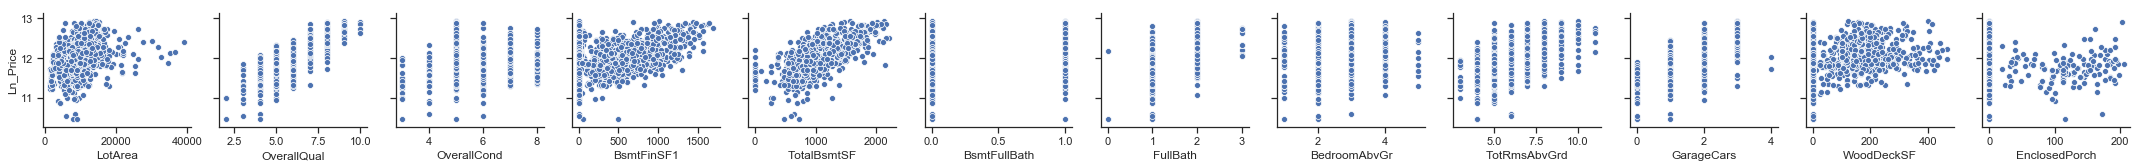

In [68]:
sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = ames_lowVIF.drop(columns=['SalePrice','Ln_Price']).columns

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data=ames_lowVIF, y_vars=['Ln_Price'], x_vars=x_columns)
plt.show()

I'd guess that the error will change the most for BsmtFinSF1, TotalBsmtSF, FullBath, and maybe TotalRmsAbvGrd.  Let's see.

In [69]:
X = ames_lowVIF.drop(columns=['SalePrice','Ln_Price'])
y = ames_lowVIF['Ln_Price']
X.insert(0,'const',1.0)
model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Ln_Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     444.5
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:24:32   Log-Likelihood:                 656.49
No. Observations:                1251   AIC:                            -1287.
Df Residuals:                    1238   BIC:                            -1220.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.1509      0.048    210.527

The STERRs are basically the same for all the variables.  Within the ones I mentioned, two went down, one went up, and one is the same.  All these changes were minimal.

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

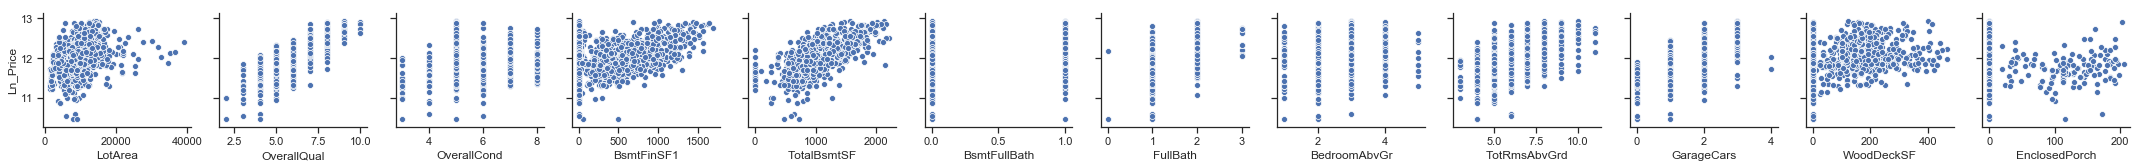

In [70]:
sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = ames_lowVIF.drop(columns=['SalePrice','Ln_Price']).columns

# Only plot the scatterplot of x variables with our y variable
sns.pairplot(data=ames_lowVIF, y_vars=['Ln_Price'], x_vars=x_columns)
plt.show()

Oof.  Nothing here has a clear curve to it, so I don't expect that polynomial terms will really change much of anything.  Maybe WoodDeckSF?

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

In [114]:
# Re-setting our X and y values, just to be sure.
X = ames_lowVIF.drop(columns=['SalePrice','Ln_Price'])
y = ames_lowVIF['Ln_Price']

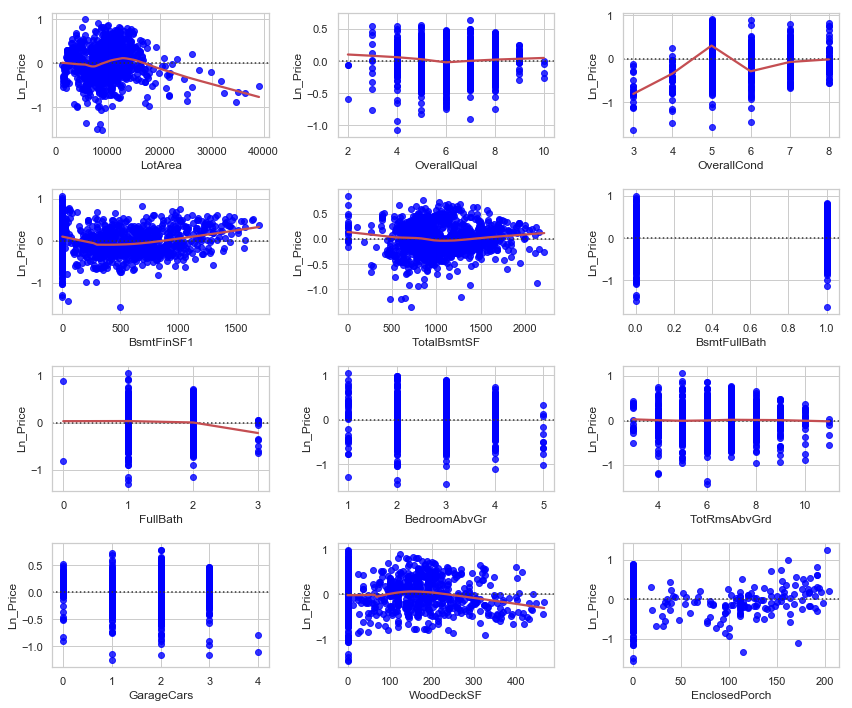

In [120]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(12,10));

# Positions in the array of axes that I just made
position_list = []
for i in range(4):
    for j in range(3):
        position_list.append((i,j))
        
for col, pos in zip(X.columns, position_list):
    sns.residplot(X[col], y, lowess=True, color="r", ax=axs[pos[0]][pos[1]],
                  scatter_kws={'color':'blue'})
plt.tight_layout()

Based on these plots, I'd say that the best candidates are LotArea and OverallCond.  I'll add polynomial terms for both.

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [121]:
ames_poly = ames_lowVIF
ames_poly['LotArea_sq'] = ames_poly['LotArea']**2
ames_poly['OverallCond_sq'] = ames_poly['OverallCond']**2

X = ames_poly.drop(columns=['SalePrice','Ln_Price'])
y = ames_poly['Ln_Price']
X.insert(0,'const',1.0)
model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Ln_Price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     397.7
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:24:00   Log-Likelihood:                 674.28
No. Observations:                1251   AIC:                            -1319.
Df Residuals:                    1236   BIC:                            -1242.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.6646      0.142     68.

/anaconda3/envs/sandbox/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 13
  'rank is %d' % (J, J_), ValueWarning)


Adding those last 2 polynomial terms slightly improved the Adjusted R^2 value, which means that they were helpful!  Note that both the var^2 coefficients are negative, which indicates that higher values of those variables are associated with lower prices than you'd get from just fitting a straight line to the data.  They mean that for both of those variables there's diminishing returns.